In [7]:
import copy

import pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from scipy import signal
from scipy.signal import find_peaks_cwt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

In [95]:
filePath = "..//..//data//"
#fileName = "output2022-04-27T15_16_04.csv"
fileName = "Raw1.csv"
data = pd.read_csv(filePath + fileName)
marked_point=np.array([0,58002,63002,57502,65002,0,0,65502,59002,0,0,48501,46502,0,65500,0,56502,0,61002,0,67002,78502,71502,80502,78501])




In [4]:
def knn_norm(data, k=7, mode="max"):
    lenth = len(data)
    output_list = []
    for i in range(lenth - k):
        if mode == "max":
            output_list.append((np.max(data[i:i + k])))
        elif mode == "mean":
            output_list.append((np.mean(data[i:i + k])))
        elif mode == "min":
            output_list.append((np.min(data[i:i + k])))

    return np.hstack((np.ones(lenth-len(output_list))*output_list[0],np.array(output_list)))

## 1. Hatching Onset Point Detection

From our analysis of experimental video recordings, drosophila embryos did not actually start to move during the initial stages of system operation. And the motion signal we capture is actually a series of noise in the experimental environment. By intercepting the first 5000 frames of motion in the time series, the maximum value is obtained, and then all signals below this threshold are filtered. The first spike is then seen as a signal for the start of hatching.

In [24]:

onset_points=[]
diffs=[]
filtered_signals=[]
for j in tqdm.tqdm(range(24)):
    no=j+1
    normBright = np.array(data["Item" + str(no) + ".avgBright"])
    normBright_max = knn_norm(normBright, 60, "max")
    normBright_min = knn_norm(normBright, 60, "min")
    diff = normBright_max - normBright_min
    diffs.append(copy.deepcopy(diff))
    cut= diff[0:5000]
    threshold= np.max(cut)
    onset_points.append(np.where(diff>threshold)[0][0])
    diff[np.where(diff<=threshold)[0]]=0
    diff[np.where(diff>threshold)[0][0]]=0
    filtered_signals.append(diff)
print("Hatching onset point list is:",onset_points)

100%|██████████| 24/24 [00:13<00:00,  1.72it/s]

Hatching onset point list is: [12638, 6325, 10480, 6251, 8481, 15360, 9285, 7129, 5026, 5494, 7724, 5623, 5260, 5331, 11453, 14128, 6577, 6595, 7962, 14035, 11625, 5685, 9352, 6959]


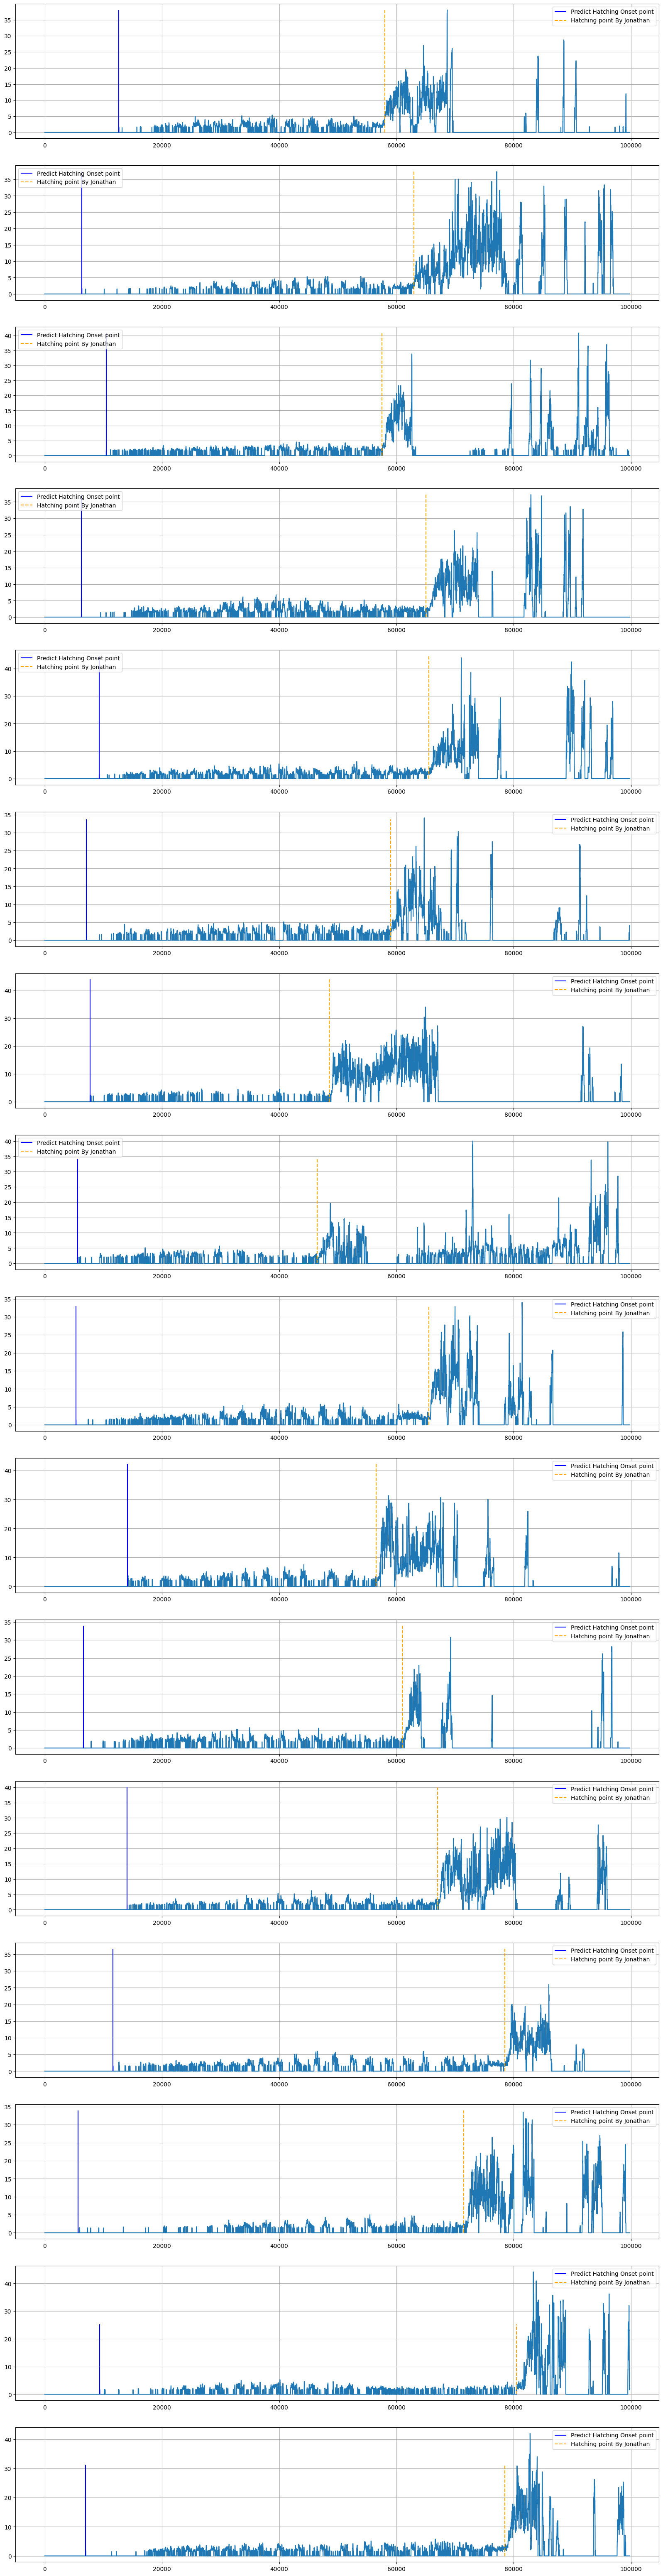

In [25]:

vaildlenth=len(marked_point[marked_point!=0])
f, ax = plt.subplots(vaildlenth, 1, figsize=(20, 5*vaildlenth))
i=0
for j in range(24):
    if marked_point[j+1]!=0:
        ax[i].plot(filtered_signals[j])
        ax[i].vlines(onset_points[j],0,np.max(filtered_signals[i]), linestyles='-',color='blue', label='Predict Hatching Onset point')
        ax[i].vlines(marked_point[j+1], 0,np.max(filtered_signals[i]), linestyles='--', color='orange', label='Hatching point By Jonathan')
        ax[i].grid()
        ax[i].legend()
        i+=1

## 2. Hatching Complete Point Detection


This method uses a sliding window (window size is 60) to calculate the maximum and minimum values of brightness within the window, thereby generating two new time series. By calculating the difference between the two series we can obtain a time series describing the magnitude of Embryo's motion. By labeling the data, we can find that the hatching point appears at the starting point of the first peak. Using find_peaks of scipy.signal can find these local minima, so as to realize the automatic labeling of hatching points.

In [26]:
hatching_points=[]
maxss=[]
for j in tqdm.tqdm(range(24)):
    #if marked_point[j+1]!=0:
    no=j+1
    #plt.figure(figsize=(20,5))
    #current=np.array(data["Item"+str(no)+".avgBright"])
    ###normBright,normBright_max,normBright_mean,diff,normBright_mean1=normBright_MaxMin_diff(np.array(data["Item3.avgBright"]),60)
    #norm_max=knn_norm(current, 60,"max")
    #norm_min=knn_norm(current, 60,"min")
    #diff=norm_max-norm_min
    ndiff=knn_norm(diffs[j],8000,"mean")
    increase_point=np.where(ndiff>np.mean(ndiff)*1.2)[0][0]
    cut=ndiff[:increase_point]
    x = np.linspace(0, len(cut), len(cut))
    maxs =find_peaks_cwt(cut[10000:],500)
    maxs+=10000
    cuted=maxs[-2]
    maxss.append((maxs[-2],maxs[-1]))
    cut=cut[maxs[-2]:maxs[-1]]
    mins =find_peaks_cwt(cut**-1,80)
    predict=0
    reverse_min = mins[::-1]
    for i in range(len(mins)):
        if i ==0:
            continue
        else:
            if cut[reverse_min[i]] > cut[reverse_min[i-1]]:
                predict=reverse_min[i-1]+maxs[-2]
                #hatching_points.append(predict)
                break
    if predict<(maxs[-2]+maxs[-1])/2:
        hatching_points.append(int((maxs[-1]+(maxs[-2]+maxs[-1])/2)/2))
    else:
        hatching_points.append(predict)
print("Hatching complete point list is:",hatching_points)

100%|██████████| 24/24 [01:33<00:00,  3.90s/it]

Hatching complete point list is: [57077, 62588, 56780, 65722, 69063, 68660, 66225, 59206, 62102, 70426, 48117, 45291, 69342, 65226, 71990, 57118, 69456, 59452, 86876, 66131, 78450, 71380, 80081, 77238]


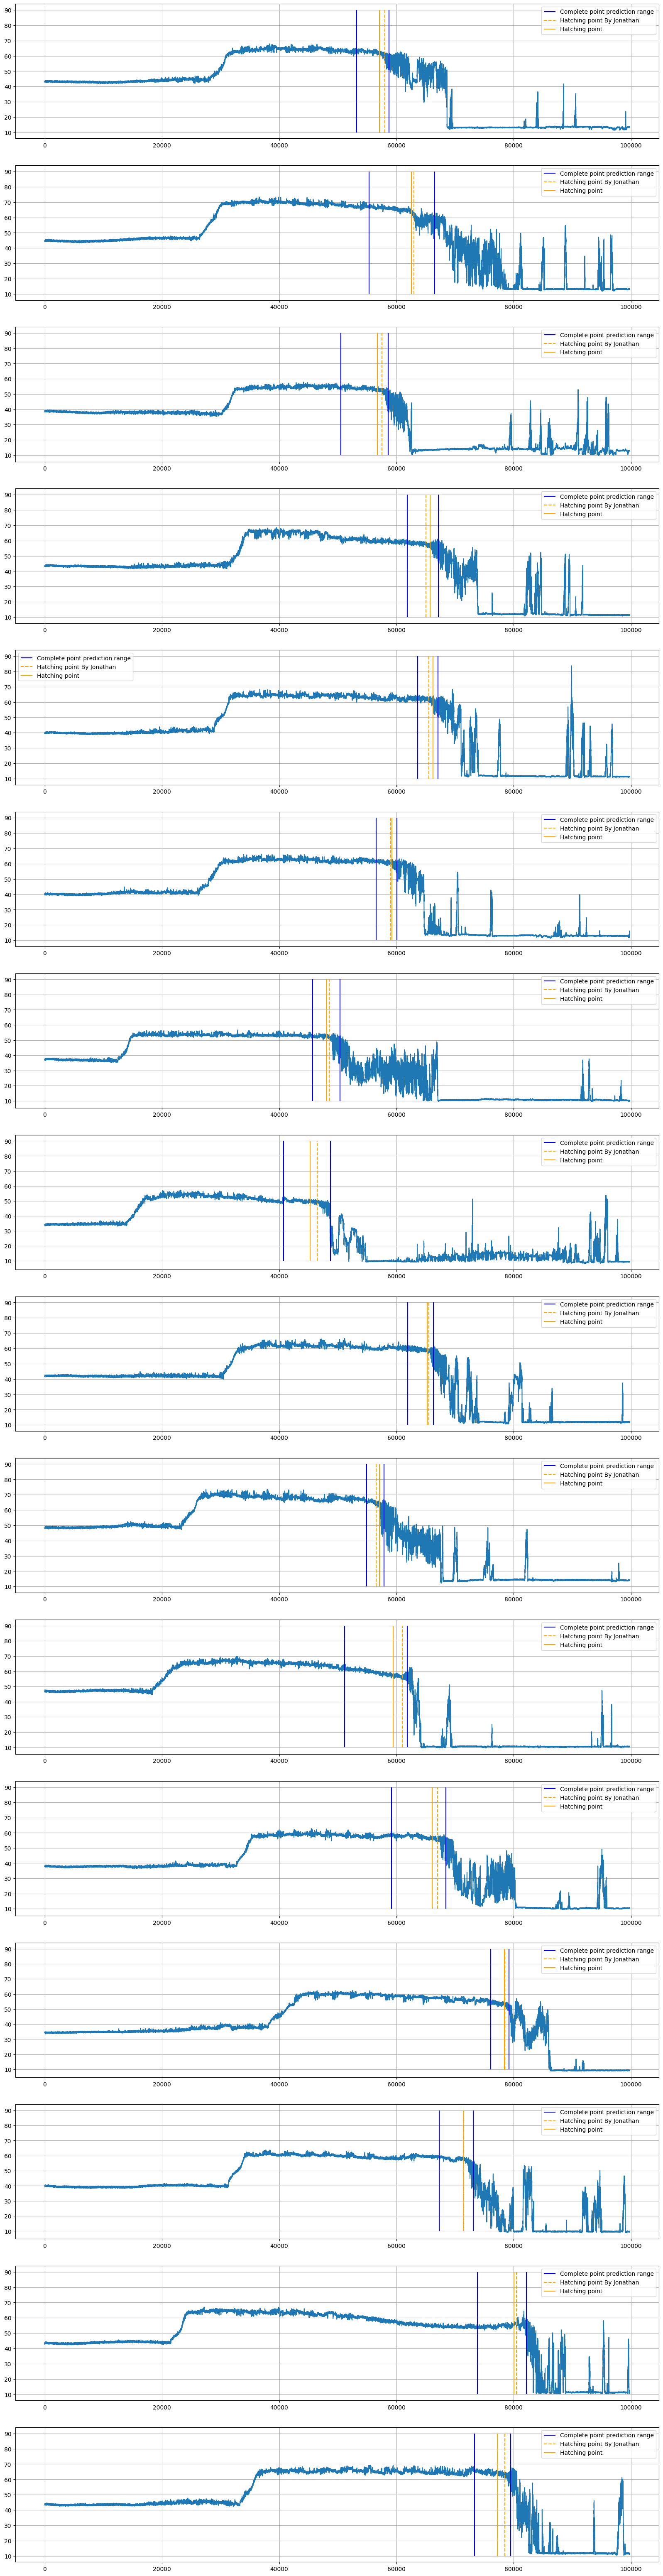

In [94]:
vaildlenth=len(marked_point[marked_point!=0])
f, ax = plt.subplots(vaildlenth, 1, figsize=(20, 5*vaildlenth))
i=0
for j in range(24):
    if marked_point[j+1]!=0:
        ax[i].plot(data["Item"+str(j+1)+".avgBright"])
        ax[i].vlines(maxss[j][0], 10,90, linestyles='-', color='blue',label="Complete point prediction range")
        ax[i].vlines(maxss[j][1], 10,90, linestyles='-', color='blue')
        ax[i].vlines(marked_point[j+1], 10,90, linestyles='--', color='orange', label='Hatching point By Jonathan')
        ax[i].vlines(hatching_points[j], 10,90, linestyles='-', color='orange', label='Hatching point')
        ax[i].grid()
        ax[i].legend()
        i+=1

## 3.Total Movement Quantity
Sum of values above threshold (between onset and complete)

In [32]:
Sum_above_threshold=[]
for i in range(24):
    Sum_above_threshold.append(len(np.where(filtered_signals[i][onset_points[i]:hatching_points[i]]!=0)[0]))
print("Total Movement Quantity: ",Sum_above_threshold)

Total Movement Quantity:  [19892, 17988, 21322, 31936, 22404, 22108, 34734, 22772, 20149, 30152, 10383, 13359, 21778, 28858, 27947, 17069, 24817, 21074, 29521, 20508, 26975, 18157, 24017, 34309]


## 4. Average Movement Magnitude
Average of values above threshold

In [35]:
Average_of_values=[]
for i in range(24):
    Average_of_values.append(np.average(data["Item" + str(i+1) + ".avgBright"][np.where(filtered_signals[i][onset_points[i]:hatching_points[i]]!=0)[0]]))
print("Average Movement Magnitude: ",Average_of_values)

Average Movement Magnitude:  [50.93240388095717, 62.10072270402491, 43.45407536816433, 53.83594423221443, 56.147460676664885, 39.47432381943188, 53.16786411009385, 52.210096873353244, 49.35774018561715, 47.042935692491376, 47.258705769045555, 45.81606145669587, 47.415798971439074, 52.165382909418526, 44.12431395140803, 57.68498078387721, 63.87757891767739, 58.47253786656544, 52.57114037464855, 46.37003549834211, 45.80734761816497, 53.995227460483555, 57.69336594911937, 55.91292969774695]


## 5. Duration between movement onset and hatching (as frames or hours/minutes).

In [39]:
Duration=[]
for i in range(24):
    Duration.append(len(filtered_signals[i][onset_points[i]:hatching_points[i]]))
print("Duration between movement onset and hatching: ",Duration)


Duration between movement onset and hatching:  [44439, 56263, 46300, 59471, 60582, 53300, 56940, 52077, 57076, 64932, 40393, 39668, 64082, 59895, 60537, 42990, 62879, 52857, 78914, 52096, 66825, 65695, 70729, 70279]


## 6. Percentage of time moving
number of frames above threshold/ total frames

In [41]:
Moving_Percentage=[]
for i in range(24):
    Moving_Percentage.append(len(np.where(filtered_signals[i][onset_points[i]:hatching_points[i]]!=0)[0])/len(filtered_signals[i]))
print("Percentage of time moving: ",Moving_Percentage)

Percentage of time moving:  [0.19930465798992056, 0.1802278397306802, 0.21363231035899286, 0.3199775566844009, 0.22447323334034686, 0.22150750949332212, 0.3480116625086417, 0.22816034947448577, 0.20187962768142514, 0.3021030589036841, 0.1040307794042502, 0.13384832727163426, 0.21820112817738235, 0.2891380364102718, 0.2800104201108139, 0.17102006873265402, 0.24864989429599127, 0.21114751470337753, 0.29578085705411444, 0.20547656977967477, 0.27027162423477313, 0.1819211077379342, 0.2406344244391676, 0.3437534441472041]


## 7 Average bout length
at some point there are burst of movement intersped with no movement


In [47]:
Average_bout=[]
for i in range(24):
    pos = np.where(filtered_signals[i] > 0)[0]
    split = np.where(np.diff(pos) != 1)[0] + 1
    arr=np.split(filtered_signals[i][pos],split)
    lenths=[]
    for j in arr:
        lenths.append(len(j))
    Average_bout.append(np.mean(lenths))
print(" Average bout length:", Average_bout)


 Average bout length: [150.93607305936072, 168.6304347826087, 118.71875, 142.328025477707, 226.4391304347826, 143.34076433121018, 144.6832298136646, 140.1788617886179, 161.40802675585283, 138.30699088145897, 182.29268292682926, 145.52083333333334, 112.37971698113208, 131.46496815286625, 130.36387434554973, 174.76536312849163, 139.43213296398892, 112.87698412698413, 98.1264637002342, 138.61048689138576, 139.0272373540856, 128.4920634920635, 94.42897727272727, 130.6326530612245]


## 8. FFT Calculation
Bin trace into 30min periods and do fft on each bin. compare differences between them.


<function matplotlib.pyplot.show(close=None, block=None)>

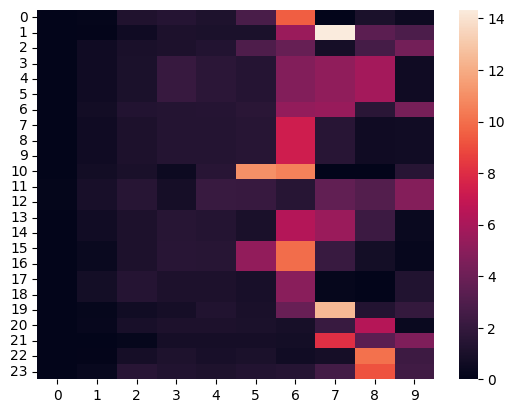

In [79]:
import seaborn as sns
from scipy.fft import rfft,rfftfreq
output=[]
for j in range(24):
    if marked_point[j+1]!=0:
        split_trace=np.split(filtered_signals[j][:99800],10)
        each_trace=[]
        for i in split_trace:
            each_trace.append(np.mean(i))
    output.append(each_trace)
ax=sns.heatmap(output)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

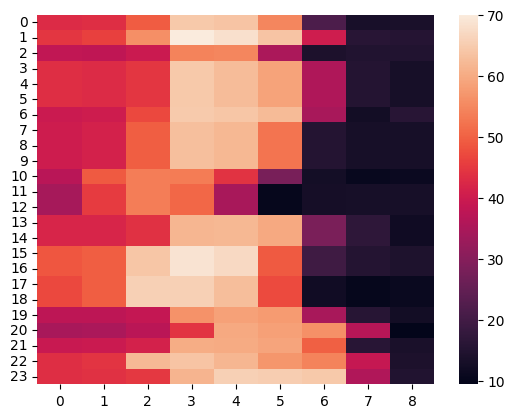

In [91]:
output=[]
for j in range(24):
    if marked_point[j+1]!=0:
        split_trace=np.split(np.array(data["Item" + str(j+1) + ".avgBright"])[:99000],9)
        each_trace=[]
        for i in split_trace:
            each_trace.append(np.mean(np.abs(i)[1:]))
    output.append(each_trace)
ax=sns.heatmap(output)
plt.show

In [92]:

'''
test1=np.array(data["Item1.avgBright"])[:5000]
plt.figure(figsize=(20,5))
n    = len(test1)
yf   = rfft(test1)
data_step=0.001
xf   = rfftfreq(n,data_step)
plt.grid()
plt.plot(xf,np.abs(yf))
plt.xlim(1)
plt.ylim(-1,100)'''

'\ntest1=np.array(data["Item1.avgBright"])[:5000]\nplt.figure(figsize=(20,5))\nn    = len(test1)\nyf   = rfft(test1)\ndata_step=0.001\nxf   = rfftfreq(n,data_step)\nplt.grid()\nplt.plot(xf,np.abs(yf))\nplt.xlim(1)\nplt.ylim(-1,100)'